В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [21]:
path = "../../../data/"
raw = pd.read_csv(path + "train.csv", index_col=0)

cols = list(raw.columns)

target_col = 'Exited'
input_cols = raw.drop(columns=['Exited']).columns.tolist()
input_cols.remove('CustomerId')
input_cols.remove('Surname')

train, val = split_train_val(raw, target_col)

train_input, train_target = separate_inputs_targets(train, input_cols, target_col)
val_input, val_target = separate_inputs_targets(val, input_cols, target_col)

print(train_input.shape, train_target.shape, val_input.shape, val_target.shape)


(12000, 10) (12000,) (3000, 10) (3000,)


In [22]:
display(train_input.head(), val_input.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
7180,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
6490,714.0,Germany,Male,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32
3646,593.0,France,Male,41.0,5.0,0.00,2.0,1.0,1.0,38196.24
5306,731.0,France,Female,38.0,2.0,0.00,2.0,0.0,1.0,116971.05
652,673.0,France,Female,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76
2627,678.0,Spain,Female,30.0,4.0,0.00,2.0,1.0,0.0,143681.85


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [23]:
cat_cols = train_input.select_dtypes(include='object').columns.tolist()
numeric_cols = train_input.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols    

['Geography', 'Gender']

In [24]:
binary = train_input[numeric_cols].nunique()
binary = binary[binary == 2].index.tolist() # add 'HasCrCard', 'IsActiveMember' as categorical data (1/0)
cat_cols = cat_cols + binary
print(cat_cols)

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']


In [25]:

train_input[cat_cols] = train_input[cat_cols].astype('category')
val_input[cat_cols] = val_input[cat_cols].astype('category')

train_input.dtypes

CreditScore         float64
Geography          category
Gender             category
Age                 float64
Tenure              float64
Balance             float64
NumOfProducts       float64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
dtype: object

# Висновки 1
- Окрім категоріальних колонок ['Geography', 'Gender'] також як категоріальні були позначені 'HasCrCard', 'IsActiveMember', бо це бінарні колонки і по суті своїй є категоріями

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [26]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def evaluate_model(model, input, target, show = True):
    y_pred = model.predict_proba(input)[:, 1]
    auc = roc_auc_score(target, y_pred)
    cm = confusion_matrix(target, (y_pred > 0.5).astype(int), normalize='true').round(2)
    if show:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g')
        plt.show()
    return y_pred, auc


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=100, 
                              random_state=42,
                              learning_rate=0.1,
                              use_label_encoder=False,
                              max_depth=3,
                              enable_categorical=True)

xgb_model.fit(train_input, train_target)

c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

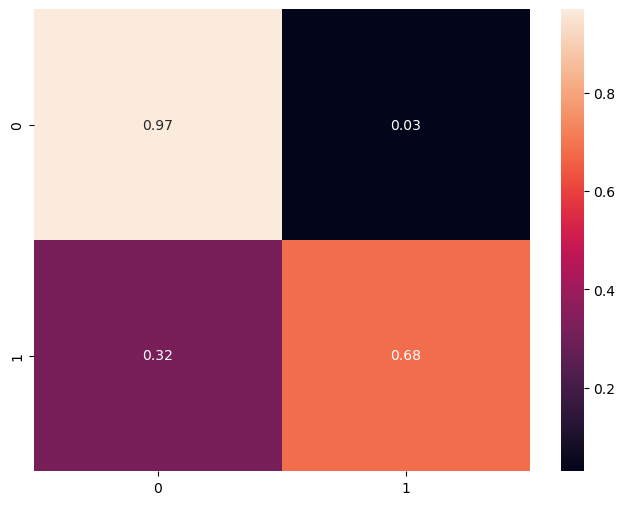

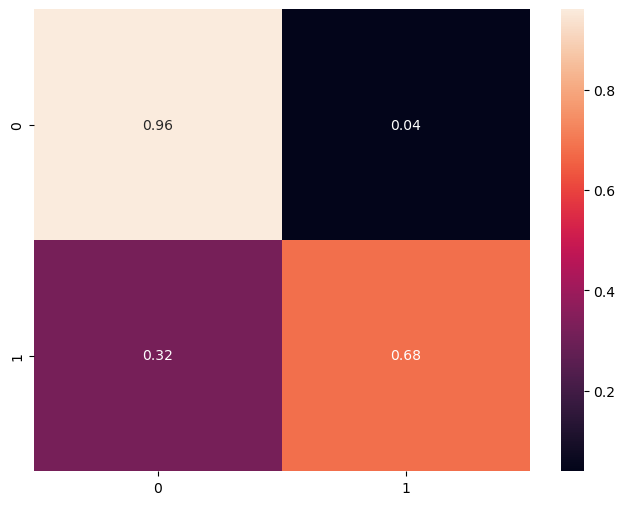

Train AUC: 0.9432361868802547, Validation AUC: 0.9371801906852322


In [28]:
train_pred, train_auc = evaluate_model(xgb_model, train_input, train_target)
val_pred, val_auc = evaluate_model(xgb_model, val_input, val_target)
print(f"Train AUC: {train_auc}, Validation AUC: {val_auc}")


# Висновки 2

- аби автоматично оброблялися категоріальні колонки ми зазначили: enable_categorical=True 
- Ми отримали дуже гарну модель. До цього точність ніколи не досягала 0.94. Тако само гарна генералізація для валідаційної вибірки

| Model         | Train AUC | Val AUC    |
|--------------|----------|------------|
| Log. Regres. | 0.8825   | 0.8796     |
| Polinom      | 0.9382   | 0.9334     |
| Decision Tree| 0.9309   | 0.9247     |
|XGB random param |0.9432 | 0.9371    |


3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        #use_label_encoder=False,
        missing=np.nan,
        #device='cuda',
        early_stopping_rounds=40,
        # eval_metric='auc',
    
    )

    clf.fit(
        train_input,
        train_target,
        eval_set=[(val_input, val_target)],
        verbose=False)
    pred, auc = evaluate_model(clf, val_input, val_target, show=False)
    return {'loss': -auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 5, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals = 20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    # use_label_encoder=False,
    missing=np.nan,
    # device='cuda',
)

final_clf.fit(train_input, train_target)
final_pred = final_clf.predict_proba(val_input)[:, 1]   
final_acu_val = roc_auc_score(val_target, final_pred)
final_acu_train = roc_auc_score(train_target, final_clf.predict_proba(train_input)[:, 1])
print(f"Train AUC: {final_acu_train}, Validation AUC: {final_acu_val}")


100%|██████████| 20/20 [00:08<00:00,  2.30trial/s, best loss: -0.9368214555182112]
Найкращі гіперпараметри:  {'colsample_bytree': 0.7188426381669529, 'gamma': 0.2809471280529643, 'learning_rate': 0.034719971651538395, 'max_depth': 7, 'min_child_weight': 12, 'n_estimators': 225, 'reg_alpha': 9.721975651760937, 'reg_lambda': 8.194997934821872, 'subsample': 0.7028003744852824}
Train AUC: 0.9413500129131014, Validation AUC: 0.9368214555182112


# Висновки 3
- На жаль, з hyperopt модель перенавчилася, треба праділити більше уваги для пошуку мінімального-максимально значення в сітці гіперпараметрів.
- Так само в ході експеримнетів якщо збільшити кількість раундів max_evals = 20 хоча б до 40, то ми будемо ближче до більш збалансованої моделі.
- Але мінус в такому типі пошуку параметрів - що кожен раз ми можемо отримувати різну модель. Декілька разів я отримувала дуже перетреновану модель, а інколи вона доволі гарно генералізувала. при тому в коді нічого не змінювалося, перезапускавмя один і той самий код

| Model         | Train AUC | Val AUC    |
|--------------|----------|------------|
| Log. Regres. | 0.8825   | 0.8796     |
| Polinom      | 0.9382   | 0.9334     |
| Decision Tree| 0.9309   | 0.9247     |
|XGB random param |0.9432 | 0.9371     |
|XGB optimal |     0.9413  |0.9368    |

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [34]:
import lightgbm as lgb

In [35]:
cat_feature_indexes = [train_input.columns.get_loc(col) for col in cat_cols]
print(cat_feature_indexes)

[1, 2, 7, 8]


[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2,7,8, will be overridden by cat_feature=1,2,7,8. Current value: categorical_feature=1,2,7,8
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

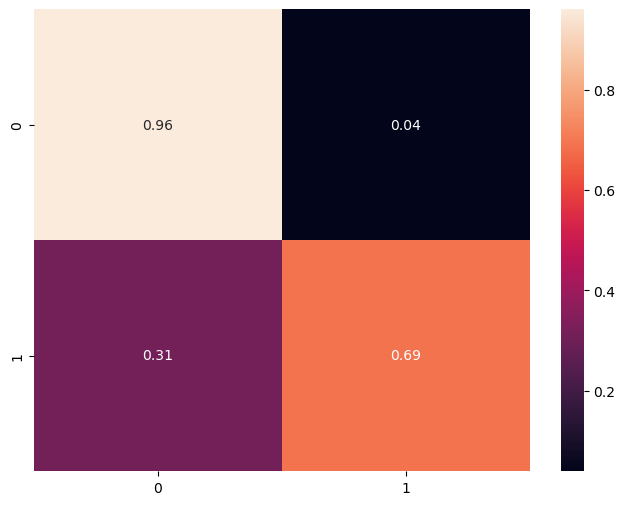

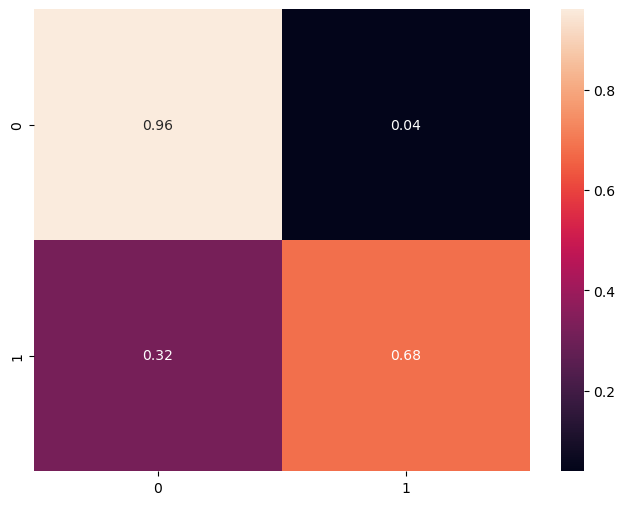

Train AUC: 0.9437089889067289, Validation AUC: 0.9377210371081693


In [36]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, 
                               random_state=42, 
                               learning_rate=0.1, 
                               max_depth=3,
                               cat_feature=cat_feature_indexes)  

lgb_model.fit(train_input, train_target, eval_set=[(val_input, val_target)])

train_pred, train_auc = evaluate_model(lgb_model, train_input, train_target)
val_pred, val_auc = evaluate_model(lgb_model, val_input, val_target)
print(f"Train AUC: {train_auc}, Validation AUC: {val_auc}")

# Висновки 4

- Знаходимо індекси для категоріальних колонок =cat_feature_indexes = [1, 2, 7, 8] та передаємо ці індекси до класифікатора : cat_feature=cat_feature_indexes
- На даному етапі lightgbm трохи кращий за XGB з рандомними параметрами, але це десятитисячний знак після коми(на 0.06% краще). Тому можна сказати що дві моделі однаково добре працюють
 
| Model         | Train AUC | Val AUC    |
|--------------|----------|------------|
| Log. Regres. | 0.8825   | 0.8796     |
| Polinom      | 0.9382   | 0.9334     |
| Decision Tree| 0.9309   | 0.9247     |
|XGB random param |0.9432 | 0.9371     |
|XGB optimal |     0.9413  |0.9368    |
|lightgbm random param | 0.9437|0.9377|


5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [37]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_input, train_target, eval_set=[(val_input, val_target)])
    pred = clf.predict(val_input)
    pred, auc = evaluate_model(clf, val_input, val_target, show=False)
    # accuracy = accuracy_score(val_target, pred)

    return {'loss': -auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)


final_lgb.fit(train_input, train_target)
final_pred = final_lgb.predict_proba(val_input)[:, 1]   
final_acu_val = roc_auc_score(val_target, final_pred)
final_acu_train = roc_auc_score(train_target, final_lgb.predict_proba(train_input)[:, 1])
print(f"Train AUC: {final_acu_train}, Validation AUC: {final_acu_val}")

[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2,7,8, will be overridden by cat_feature=1,2,7,8. Current value: categorical_feature=1,2,7,8
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

# Висновки 5

- Схоже що під час пошуку оптимальних параметрів модель трохи почала перенавчатися. Тренувальна точність зросла, але валідаційна впала
-  Великий мінус моделі що вона довго працює та перевантажує систему, що якась інша робота за комп'ютером стає неможливою.

| Model         | Train AUC | Val AUC    |
|--------------|----------|------------|
| Log. Regres. | 0.8825   | 0.8796     |
| Polinom      | 0.9382   | 0.9334     |
| Decision Tree| 0.9309   | 0.9247     |
|XGB random param |0.9432 | 0.9371     |
|XGB optimal |     0.9413  |0.9368    |
|lightgbm random param | 0.9437|0.9377|
|lightgbm optimal |     0.9476  |0.0.9365    |

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [ ]:
import joblib
bank_1 = {
    'model': final_clf,
    'params': best,
    'category_cols': cat_cols,
    'numeric_cols': numeric_cols,
    'target_col': target_col
}
joblib.dump(bank_1, 'best_model_1DS.joblib')

df_test = pd.read_csv(path + 'test.csv')
X_test = df_test[input_cols].copy()
X_test[cat_cols] = X_test[cat_cols].astype('category')

prob_test =  final_clf.predict_proba(X_test)[:,1]

submit = pd.read_csv(path + 'sample_submission.csv')
submit['Exited'] = prob_test
submit.to_csv('submission_XGM_hyperopt9375.csv', index=False)
# # Train AUC: 0.9440746387544883, Validation AUC: 0.9372103710816929
# KAGGLE 0.93839

C:\Users\Olha Shaposhnyk\AppData\Local\Temp\ipykernel_1852\2870801363.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


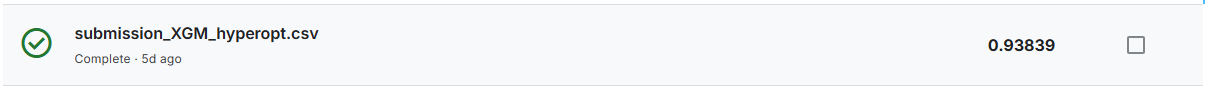

In [44]:
from IPython.core.display import Image, display
display(Image('Kaggle_xgb.png', width=900, unconfined=True))

# Висновки 6

- Після додаткової оптимізації параметрів (підбору кращої сітки параметрів) була досягнута краща точність для XGM  і на Kaggle точність досягнула 0.93839.

- Прості базові алгоритми як Логістична регресія показали найгірший результат.
- Всі інші базові моделі (Поліноміальна модель, Decision Tree, KNN) справилися з задачею однаково непогано
- Бустінгові алгоритми перевершили точність та значно покращили результат точності особливо для класу 1 (по confusion matrix ми тепер правильно розпізнаємо клас 1 в 70% випадків)
    - Також для XGB різниця між Train AUC та Val AUC невелика, що свідчить про хорошу генералізацію.
    - Вони показують краще точність бо кожне наступне навчання відбувається з урахуванням помилок минулих моделей та охопити нелініцні залежності в даних. Також модель більш "розумно" оновлює свої вага за допомогою другої похідної. 
    - lightgbm теж непоганий вибір, але вона дає майже таку саме точність як XGB але при цьому навчається набагато довше, тому для поточного датасету я б її не обирала

| Model         | Train AUC | Val AUC    |
|--------------|----------|------------|
| Log. Regres. | 0.8825   | 0.8796     |
| Polinom      | 0.9382   | 0.9334     |
| Decision Tree| 0.9309   | 0.9247     |
|KNN            |0.9364|0.9151|
|XGB random param |0.9432 | 0.9371     |
|XGM optimal |     0.9413  |0.9368    |
|lightgbm random param | 0.9437|0.9377|
|lightgbm optimal |     **0.9476** |0.0.9365    |
|**XGB top model**|  0.94407|**0.9372** |